<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/2023TimeSeriesForecasting/model_selection_and_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model selection and validation


## CV for time series
A standard 5-folds CV strategy can be depicted like in the following picture:

![](https://raw.githubusercontent.com/nepslor/teaching/main/2023TimeSeriesForecasting/figs/standard_CV.png)

On the x axis we have a repartition of the initial dataset, while on the y axis we have the 5 validation folds: white squares represent training data, while gray folds represent test data. 

There are mainly three reasons why the naive CV could fail to capture generalized performances of a forecasting algorithm:
1. IID assumption: CV scores won't be representative in the case the target and covariates will undergo a distribution shift
2. the testing set is used multiple times in the process of developing a model, leading to multiple testing and selection bias.
3. Leakage of information from the training set to the test set

While these three aspects affects all machine learning algorithms, for the third one.

## Should we use the past to test forecasts?
The earliest and simplest mechanism designed to tackle
First, the earliest fold of the dataset is completely unrepresented
in any performance measurements, and the other early
folds are fit on very limited training data, using hyper-
parameters that are unlikely to work well on the full
dataset. Second, given the expanding size of each fold, the
earliest time periods—the ones least relevant to current
performance—receive the highest weight in training.


![](https://raw.githubusercontent.com/nepslor/teaching/main/2023TimeSeriesForecasting/figs/TS_CV.png)

![](https://raw.githubusercontent.com/nepslor/teaching/main/2023TimeSeriesForecasting/figs/purged_TS_CV.png)

In [302]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from IPython.display import display


,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan


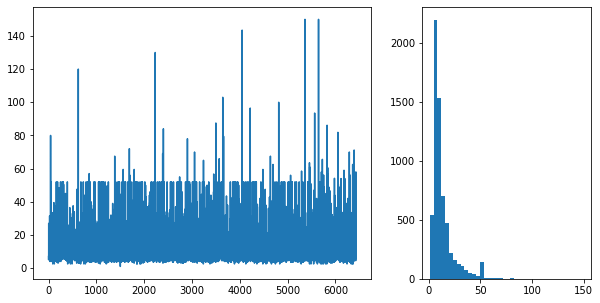

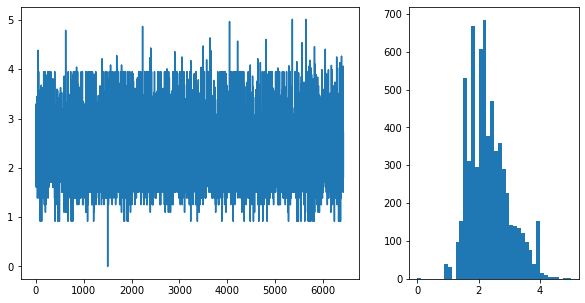

In [119]:
# load and show original dataset
data = sb.load_dataset('taxis')
display(data.head())

fig, ax = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={'width_ratios': [2, 1]})
data['fare'].plot(ax=ax[0])
ax[1].hist(data['fare'], bins=40);

from scipy.stats import boxcox
# seems worth a log transform
data['fare'] = np.log(data['fare'])
fig, ax = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={'width_ratios': [2, 1]})
data['fare'].plot(ax=ax[0])
ax[1].hist(data['fare'], bins=40);


In [169]:
def get_hankel(x, n_past, n_future):
  """
  Form past and future Hankel matrices from x 
  """
  n = len(x)
  past = np.vstack([x[i:-n_past+i] for i in range(n_past)]).T
  future = np.vstack([x[i+n_past:-n_future + i] for i in range(n_future)]).T
  n_max = np.minimum(past.shape[0], future.shape[0])
  return pd.DataFrame(past[:n_max, :], index=x.index[:n_max]), pd.DataFrame(future[:n_max, :], index = x.index[:n_max])

# get the regressors and target matrices, concatenate in a multiindex dataframe and show them 
n_past, n_future = 6, 4
x, y = get_hankel(data['fare'].iloc[:110], n_past, n_future)
dataset = pd.concat({'x':x, 'y':y}, axis=1)
display(dataset.head())

x                                                           y  \
          0         1         2         3         4         5         0   
0  1.945910  1.609438  2.014903  3.295837  2.197225  2.014903  2.564949   
1  1.609438  2.014903  3.295837  2.197225  2.014903  2.564949  2.140066   
2  2.014903  3.295837  2.197225  2.014903  2.564949  2.140066  2.708050   
3  3.295837  2.197225  2.014903  2.564949  2.140066  2.708050  2.079442   
4  2.197225  2.014903  2.564949  2.140066  2.708050  2.079442  2.833213   

                                 
          1         2         3  
0  2.140066  2.708050  2.079442  
1  2.708050  2.079442  2.833213  
2  2.079442  2.833213  1.871802  
3  2.833213  1.871802  1.871802  
4  1.871802  1.871802  2.351375

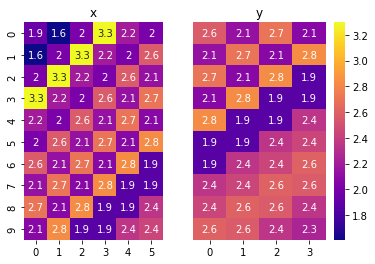

In [170]:
def plot_hankels(dataset, n=5, vmin=None, vmax=None, ratios=None, **kwargs):
  vmin = vmin if vmin is not None else dataset.iloc[:n, :].min().min() 
  vmax = vmax if vmax is not None else dataset.iloc[:n, :].max().max()
  ratios = [1, 1.2] if ratios is None else ratios
  fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': ratios}, **kwargs)
  sb.heatmap(dataset['x'].iloc[:n, :], ax=ax[0], cbar=False,vmax=vmax, vmin=vmin, cmap='plasma', annot=True)
  sb.heatmap(dataset['y'].iloc[:n, :], ax=ax[1],vmax=vmax, vmin=vmin, cmap='plasma', annot=True)
  ax[0].set_title('x')
  ax[1].set_yticks([])
  ax[1].set_title('y')

def plot_folds(datasets, n, vmin=None, vmax=None, **kwargs):
  vmin = vmin if vmin is not None else np.min([d.iloc[:n, :].min().min() for d in datasets]) 
  vmax = vmax if vmax is not None else np.max([d.iloc[:n, :].max().max() for d in datasets])
  for d in datasets:
    plot_hankels(d, n, vmin, vmax, **kwargs)


plot_hankels(dataset, n=10)

generate 10 folds with no hops, plot test and training set


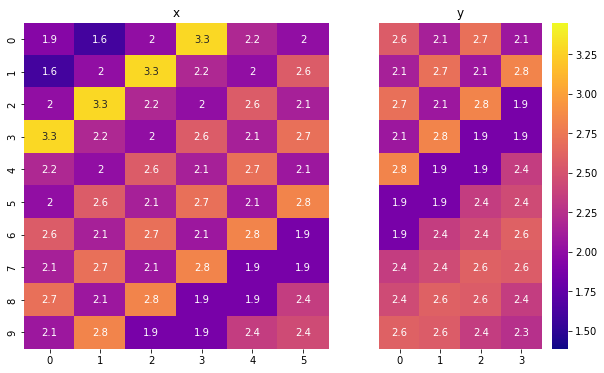

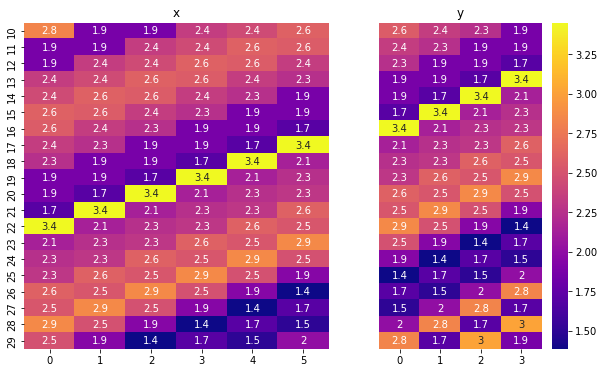

generate 10 folds with 4 hops, plot test and training set


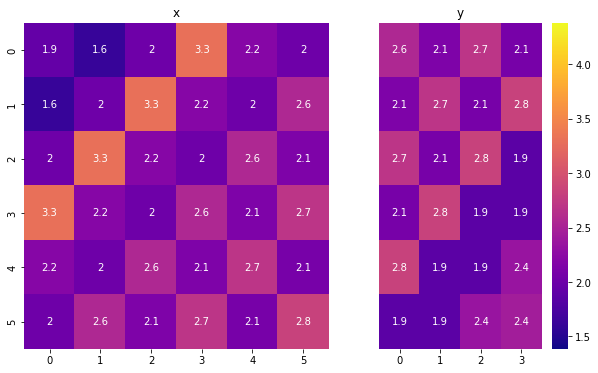

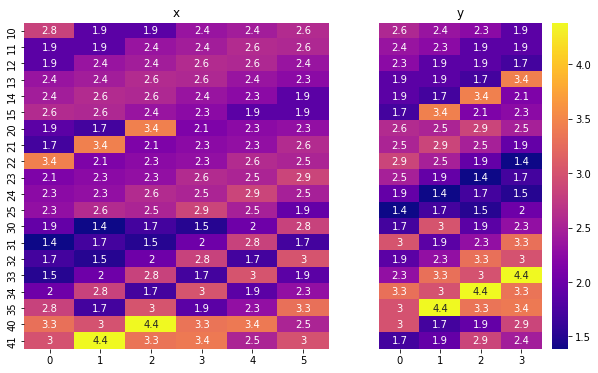

In [176]:
def gen_cvfolds(data, k, hops):
  n_f = np.floor(len(data)/k).astype(int)
  folds = []
  for f in range(n_f):
    data_f = data.iloc[n_f*f:n_f*(f+1), :]
    folds.append(data_f.iloc[range(len(data_f)-hops), :])

  for f in range(n_f):
    tr_idx = np.delete(np.arange(n_f), f)
    data_tr = pd.concat([folds[i] for i in tr_idx], axis=0)
    yield folds[f], data_tr

print('generate 10 folds with no hops, plot test and training set')
g = gen_cvfolds(dataset, k=10, hops=0)
plot_folds(next(g), n=20, figsize=(10, 6), ratios=[6, 4])
plt.pause(1)

hops = dataset['y'].shape[1]
print('generate 10 folds with {} hops, plot test and training set'.format(hops))
g = gen_cvfolds(dataset, k=10, hops=hops)
plot_folds(next(g), n=20, figsize=(10, 6), ratios=[6, 4])


TypeError: ignored